# Anomaly benchmark UCR archive

In [1]:
import sys 
sys.path.append("../../1.2-HyperParameterTuning/")

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import re
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

from sklearn.preprocessing import StandardScaler


In [2]:
class UCRData(object):
    def __init__(self,data_dir,stride=5,winsize=100,norm=True):
        list_files=os.listdir(data_dir)
        list_data_files=[ os.path.join(data_dir,i) for i in list_files]

        self.indexes=[]
        for j in list_files:   
            self.indexes.append([int(i.split(".")[0]) for i in j.split("_")[-3:]])

        self.dir_data_files={int(i.split("_")[0]):{"path":j,"index":ind} for i,j,ind in zip(list_files,list_data_files,self.indexes)}


        self.window_size=winsize
        self.norm=norm
        self.stride=stride

        self.train=None
        self.start=None
        self.end=None
        self.ID=None

        #pues lo datos no los vamos a cargar aun, lo que vamos a hacer es llamar a una funcion que los carga


    def load_ID(self,ID):
        #cuando llamamos a esto, cambiamos el estado interno del objeto para que tenga el conjunto de datos
        #que queremos 
        self.current_ID=ID
        data_aux=np.loadtxt(self.dir_data_files[ID]["path"])[...,np.newaxis]
        self.train,self.start,self.end=self.dir_data_files[ID]["index"]
        if self.norm:
            scaler=StandardScaler()
            data_aux=scaler.fit_transform(data_aux)
        
        
        self.sine_wave=torch.from_numpy(data_aux) #esto es necesario porque luego lo usa otra clase
        self.length=self.sine_wave.shape[0]
        #y vamos a enventanar
        aux=[]
        for i in range(0,data_aux.shape[0]-self.window_size,self.stride):
            aux.append(data_aux[i:(i+self.window_size)])
        self.array=torch.tensor(np.array(aux))
        #self.sensores_data_tensor=torch.from_numpy(self.sensores_data_array)
        self.list_anomalies=[list(range(self.start,self.end))]

    def __len__(self):
        return self.array.shape[0]
    
    def __getitem__(self,index):
        return self.array[index]

In [3]:
BASE_DIR=".."
data_dir=os.path.join(BASE_DIR,"data2apply/UCR_dataAnomalyArchive")

In [4]:
data=UCRData(data_dir)

In [5]:
sorted(list(data.dir_data_files.keys()))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [6]:
data.load_ID(1)

In [7]:
data.sine_wave.shape

torch.Size([79795, 1])

In [8]:
#todo el codigo de entrenamiento aqui 
class AnomalyModel:
    def __init__(self, AnomalyTransformer,window_size=100,enc_in=1,enc_out=1, d_model=64, n_heads=3, e_layers=2, d_ff=32,
                 dropout=0.1, activation='relu',  lambda_=1e-3,max_norm=0.1,norm_type=2,sigma_a=5,sigma_b=3,clip_sigma="abs"):
        self.model = AnomalyTransformer(window_size, enc_in, enc_out, d_model, n_heads, e_layers, d_ff, dropout, activation,
                                        sigma_a=sigma_a,sigma_b=sigma_b,clip_sigma=clip_sigma, output_attention=True,)
        self.model.cuda()
        self.N=e_layers
        self.model = self.xavier_initialization(self.model)
        #self.dataset=dataset
        #self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lambda_ = lambda_
        self.max_norm=max_norm
        #self.batch_size=batch_size
        self.norm_type=norm_type
        self.window_size=window_size
        self.sigma_a=sigma_a
        self.sigma_b=sigma_b
        self.clip_sigma=clip_sigma
    @staticmethod
    def xavier_initialization(model):
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None and module.weight.dim() >= 2:
                nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        return model

    @staticmethod
    def my_kl_loss(p, q):
        res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
        return torch.mean(torch.sum(res, dim=-1), dim=1)

    @staticmethod
    def layer_association_discrepancy(Pl, Sl):
        B, Head, Height, _ = Pl.shape
        kl1 = AnomalyModel.my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
        kl2 = AnomalyModel.my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))
        ad_vector = kl1 + kl2
        return ad_vector

    @staticmethod
    def association_discrepancy(P_list, S_list):
        return torch.stack([AnomalyModel.layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

    @staticmethod
    def loss_function(x_hat, P_list, S_list, lambda_, x):
        frob_norm = (torch.linalg.norm(x_hat- x,dim=(1,2))**2).mean(axis=0) #((x_hat - x)**2).sum()
        #diss_norm = torch.mean(AnomalyModel.association_discrepancy(P_list, S_list))
        diss_norm = (torch.abs(AnomalyModel.association_discrepancy(P_list, S_list)).mean(dim=1)).mean()
        print(frob_norm, diss_norm)
        return (frob_norm.item(), diss_norm.item()), frob_norm - (lambda_ * diss_norm)

    @staticmethod
    def min_loss(output, P_layers, S_layers, x, lambda_):
        P_list = P_layers
        S_list = [S.detach() for S in S_layers]
        lambda_ = -lambda_
        _, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return loss_value

    @staticmethod
    def max_loss(output, P_layers, S_layers, x, lambda_):
        P_list = [P.detach() for P in P_layers]
        S_list = S_layers
        lambda_ = lambda_
        details, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return details, loss_value
    
    def cosine_lr_schedule_with_warmup(self, optimizer, epoch, initial_lr, total_epochs, warmup_epochs):
        if warmup_epochs!=0:
            if epoch < warmup_epochs:
                lr = initial_lr * (epoch + 1) / warmup_epochs
            else:
                adjusted_epoch = epoch - warmup_epochs
                adjusted_total_epochs = total_epochs - warmup_epochs
                lr = 0.5 * initial_lr * (1 + math.cos(math.pi * adjusted_epoch / adjusted_total_epochs))

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr


    def clip_gradients(self):
        """
        Clip gradients of the model parameters.

        Args:
            model (torch.nn.Module): The neural network model.
            max_norm (float): The maximum allowed norm for the gradients.
            norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
        """
        # Recupera todos los gradientes de los parámetros del modelo
        gradients = [param.grad for param in self.model.parameters() if param.grad is not None]

        # Calcula la norma total de los gradientes
        total_norm = torch.norm(torch.stack([torch.norm(grad, self.norm_type) for grad in gradients]), self.norm_type)

        # Calcula el factor de escalado para recortar los gradientes
        clip_coef = self.max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            # Aplica el factor de escalado a los gradientes
            for grad in gradients:
                grad.mul_(clip_coef)



    def schedule_lambda(self,epoch,num_epochs,init_lambda,final_lambda):
        self.lambda_=(final_lambda-init_lambda)/num_epochs * epoch + init_lambda
        
    def train(self,dataloader, num_epochs, initial_lr, warmup_epochs,init_lambda,final_lambda):
        optimizer = optim.Adam(self.model.parameters(), lr=initial_lr)
        self.num_epochs=num_epochs
        self.initial_lr=initial_lr
        self.model.train()
        loss_frob_diss = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")
            self.schedule_lambda(epoch,num_epochs,init_lambda,final_lambda)
            for i, (inputs) in enumerate(dataloader):
                inputs = inputs.float().to("cuda:0")
                outputs, series, prior, _ = self.model(inputs)
                #esto ya lo hacemos dentro del calculo de la perdida
                #prior = [j / torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100) for j in prior]



                loss_min = self.min_loss(outputs, prior, series, inputs, self.lambda_)
                loss_min.backward(retain_graph=True)
                #optimizer.step()
                #optimizer.zero_grad()

                details, loss_max = self.max_loss(outputs, prior, series, inputs, self.lambda_)
                loss_max.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_frob_diss.append(list(details))

                #loss_max.backward(retain_graph=True)
                #loss_min.backward()
                if self.max_norm is not None:
                    self.clip_gradients()
                #optimizer.step()
                #optimizer.zero_grad()

                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss_max.item():.4f}")
            if warmup_epochs is not None:
                self.cosine_lr_schedule_with_warmup(optimizer, epoch, initial_lr, num_epochs, warmup_epochs)

            torch.cuda.empty_cache()
            gc.collect()
        print("Entrenamiento finalizado")
        self.loss = np.array(loss_frob_diss)
    
    # def predict(self, data=None):
    #     if data is None:
    #         data = next(iter(self.dataloader)).float().to("cuda:0")
    #     else:
    #         data = torch.tensor(data).float()
    #         data = data.to("cuda:0") # .unsqueeze(0) -> esto si solo tiene un canal y no lo hemos puesto

    #     self.model.eval()
    #     with torch.no_grad():
    #         out, series, prior, sigmas = self.model(data)

    #     out = out.cpu().numpy()
    #     series = [s.cpu().numpy() for s in series]
    #     prior = [p.cpu().numpy() for p in prior]
    #     sigmas = [sigma.cpu().numpy() for sigma in sigmas]

    #     return data.cpu().detach().numpy(),out, series, prior, sigmas


    @staticmethod
    def anomaly_score(model, input=None, crit_batch_size=32):
        input = input.float().to("cuda:0")
        model.eval()
        num_batches = int(input.size(0) / crit_batch_size) + (1 if input.size(0) % crit_batch_size != 0 else 0)

        # Inicializa un tensÇor vacío para almacenar los resultados
        result = torch.empty(0, device="cuda:0")

        for i in range(num_batches):
            batch_start = i * crit_batch_size
            batch_end = min((i + 1) * crit_batch_size, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = model(input_batch)
            ad = F.softmax(
                -AnomalyModel.association_discrepancy(prior, series), dim=0
            )

            norm = ((out - input_batch) ** 2).sum(axis=-1)

            score = torch.mul(ad, norm)

            # Añade el resultado del lote actual al tensor de resultado
            result = torch.cat((result, score), dim=0)

        return result



#tenemos el modelo entrenado en una clase, y otra case el con tipo de datos.
#ahora necesitamos algo que nos encapsule la evaluacion de los resultados obtenidos
#para ello creamos la clase
class EvalModel(object):
    def __init__(self,model_instance,dataset_instance,hp=None,save_directory=None,batch_predict=16):
        self.model_instance=model_instance
        self.dataset=dataset_instance
        self.batch_predict=batch_predict
        self.save_directory=save_directory
        self.window_anomalies()

        #self.windowed_data2eval=self.windowed_data2eval.unsqueeze(-1) #leañadimos una dimeninsion porque oslo tiene 1 variable 
        #ya lo hace la clase dataset
        self.hp=hp #esto es una lista con los hiperparametros

        self.run_model()

        self.evaluate_model()


    def run_model(self):
        input = self.windowed_data2eval.float().to("cuda:0")
        self.model_instance.model.eval()
        num_batches = int(input.size(0) / self.batch_predict) + (1 if input.size(0) % self.batch_predict != 0 else 0)

        # Inicializa tensores vacíos para almacenar los resultados
        out_list =[]
        series_list =[]
        prior_list =[]
        sigmas_list =[]

        for i in range(num_batches):
            batch_start = i * self.batch_predict
            batch_end = min((i + 1) * self.batch_predict, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = self.model_instance.model(input_batch)
            # Añade el resultado del lote actual a los tensores de resultado
            out_list.append( out)
            series_list.append( torch.stack(series).transpose(0,1))#esto que nos devuelve con listas, asi que los haremos tensores
            prior_list.append( torch.stack(prior).transpose(0,1))
            sigmas_list.append( torch.stack(sigmas).transpose(0,1))

        # Guarda los resultados en los atributos de la clase
        self.out_list = torch.cat(out_list,dim=0)
        self.series_list = torch.cat(series_list,dim=0)
        self.prior_list = torch.cat(prior_list,dim=0) #el output son bloques x muestras x cabezas x Len x Len 
        self.sigmas_list = torch.cat(sigmas_list,dim=0)

    def window_anomalies(self):
        #pero en lugar de darle un batch del dataLoader, vamos a darle las ventanas en las que encontramos anomalias
        aux=[]
        for i in self.dataset.list_anomalies:
            if (i[0]-self.dataset.window_size//2)>0:
                init_window=i[0]-self.dataset.window_size//2
            else:
                init_window=0

            if (init_window+self.dataset.window_size)>self.dataset.sine_wave.shape[0]:
                end_window=self.dataset.sine_wave.shape[0]
                init_window=self.dataset.sine_wave.shape[0]-self.dataset.window_size
            else:
                end_window=init_window+self.dataset.window_size
            if (end_window-init_window)==self.dataset.window_size:
                aux.append(self.dataset.sine_wave[init_window:end_window])
        self.windowed_data2eval=torch.stack(aux)

    def evaluate_model(self):
        #aqui generamos todos los plot y todo, y los guardamos en el directorio indicado -> save_directory

        self.anomaly_score=AnomalyModel.anomaly_score(self.model_instance.model, self.windowed_data2eval)
        aux=AnomalyModel.anomaly_score(self.model_instance.model, self.dataset.array)
        empt=torch.empty(aux.shape[0],self.dataset.length)
        empt[:]=float("nan")
        for i,j in enumerate(aux):
            i_new=i*self.dataset.stride
            empt[i,i_new:(i_new+self.dataset.window_size)]=j
        self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))
        


    def generate_log_y_plots(self):
        #esto es la ultima funcion encargada de todo el trabajo de guarda registros y tal

        if not os.path.exists(self.save_directory):
            os.mkdir(self.save_directory)

        #variadito
        plt.figure(figsize=(19,14))
        for i in range(15):
            plt.subplot(5,3,i+1)
            plt.plot(self.out_list[i].cpu().detach().numpy(),".-",label="out")
            plt.plot(self.windowed_data2eval.cpu().detach().numpy()[i],label="inp")
            plt.plot(self.anomaly_score.cpu().detach().numpy()[i]/self.anomaly_score.cpu().detach().numpy()[i].max(),label="AnomScore")
            plt.plot(self.sigmas_list[i,:,:,:,0].mean(dim=[0,1]).cpu().detach().numpy()/self.sigmas_list[i,:,:,:,0].mean(dim=[0,1]).cpu().detach().numpy().max(),label="sigma")
        plt.legend()
        plt.tight_layout()
        name_fig="rec_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()


#=======================0
        plt.figure(figsize=(12,6))
        plt.subplot(2,1,1)
        plt.plot(self.model_instance.loss[:,0])

        for i in range(self.model_instance.num_epochs-1):
            plt.axvline(i*(self.dataset.length//self.model_instance.batch_size),color="red",alpha=0.3)

        plt.title("Reconstruction Loss",fontsize=15)
        plt.subplot(2,1,2)
        plt.plot(self.model_instance.loss[:,1])

        for i in range(self.model_instance.num_epochs-1):
            plt.axvline(i*(self.dataset.length//self.model_instance.batch_size),color="red",alpha=0.3)

        plt.title("Association Discrepancy Loss",fontsize=15)
        plt.tight_layout()
        name_fig="loss_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()

#==============================000

        plt.figure(figsize=(25,23))
        for i in range(5):
            plt.subplot(5,6,i*6+1)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,0,0].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+2)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,0,1].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+3)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,0,2].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+4)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,1,0].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+5)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,1,1].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+6)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,1,2].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
        plt.tight_layout()
        name_fig="series_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()

#===============

        plt.figure(figsize=(25,23))
        for i in range(5):
            plt.subplot(5,6,i*6+1)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,0,0].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+2)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,0,1].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+3)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,0,2].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+4)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,1,0].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+5)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,1,1].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(5,6,i*6+6)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,1,2].cpu().detach().numpy())
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,color="orange")
            plt.plot(self.windowed_data2eval[i].cpu().detach().numpy()*2.6-6,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
        plt.tight_layout()

        name_fig="prior_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()

#================

        plt.figure(figsize=(14,8))
        plt.plot(self.full_anomaly_score/self.full_anomaly_score.max(),"-r",label="Ass Dis")
        plt.plot(self.dataset.sine_wave.cpu().detach().numpy()/self.dataset.sine_wave.cpu().detach().numpy().max(),alpha=0.8,label="señal")
        plt.tight_layout()

        name_fig="critScore_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()
#=====================

        plt.figure(figsize=(14,5))

        plt.subplot(1,4,1)

        plt.hist(self.sigmas_list[:,:, :, :, 0].mean(dim=0).cpu().detach().numpy().flatten(),bins=120,alpha=0.5,histtype="stepfilled")
        plt.xlabel("sigma")
        plt.title("Media sobre todos los \n sigmas del batch",fontsize=13)

        plt.subplot(1,4,2)
        plt.hist(self.sigmas_list[:,0,:, :, 0].cpu().detach().numpy().flatten(),bins=100,alpha=0.4,histtype="stepfilled",label="Block 1")
        plt.hist(self.sigmas_list[:,1,:, :, 0].cpu().detach().numpy().flatten(),bins=100,alpha=0.4,histtype="stepfilled",label="Block 2")
        plt.xlabel("sigma")
        plt.legend()
        plt.title("Media sobre todos los sigmas del batch,\n solo segundo bloque",fontsize=12)
        plt.subplot(1,4,3)
        plt.hist(self.sigmas_list[:,0,0, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 1")
        plt.hist(self.sigmas_list[:,0,1, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 2")
        plt.hist(self.sigmas_list[:,0,2, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 3")
        plt.xlabel("sigma")
        plt.legend()
        plt.title("Media sobre todos los sigmas del batch,\n solo primer bloque, y primera cabeza",fontsize=12)

        plt.subplot(1,4,4)
        plt.hist(self.sigmas_list[:,1,0, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 1")
        plt.hist(self.sigmas_list[:,1,1, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 2")
        plt.hist(self.sigmas_list[:,1,2, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 3")
        plt.xlabel("sigma")
        plt.legend()
        plt.title("Media sobre todos los sigmas del batch,\n solo segundo bloque, y primera cabeza",fontsize=12)
        plt.tight_layout()
        name_fig="sigmas_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        
        plt.close("all")

In [9]:
BASE_DIR=".."
data_dir=os.path.join(BASE_DIR,"data2apply/UCR_dataAnomalyArchive")

In [10]:
#creamos el dataset
id=3
data=UCRData(data_dir,stride=100,winsize=100,norm=True)
data.load_ID(id)

#creamos el dataloader 
dataloader=DataLoader(data,batch_size=16,shuffle=True)

#creamos el modelo 
model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, n_heads=3, d_model=128, enc_in=1, enc_out=1, max_norm=None, sigma_a=3, sigma_b=5, clip_sigma="yes")

#entrenamos el modelo
model_instance.train(dataloader,1, 1e-4, 1, 0.01, 0.01)




Epoch: 0
tensor(277.9054, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.8858, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(277.9054, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.8858, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/50], Loss: 277.8165
tensor(206.6990, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.9034, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(206.6990, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.9034, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/50], Loss: 206.6100
tensor(208.8972, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.9029, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(208.8972, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.9029, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/50], Loss: 208.8082
tensor(212.2918, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(212.2918, device='cuda:0', grad_fn=<MeanBackward1

In [11]:
del dataloader
torch.cuda.empty_cache()
gc.collect()

#evaluamos el modelo
aux=EvalModel(model_instance,data,None,None)


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


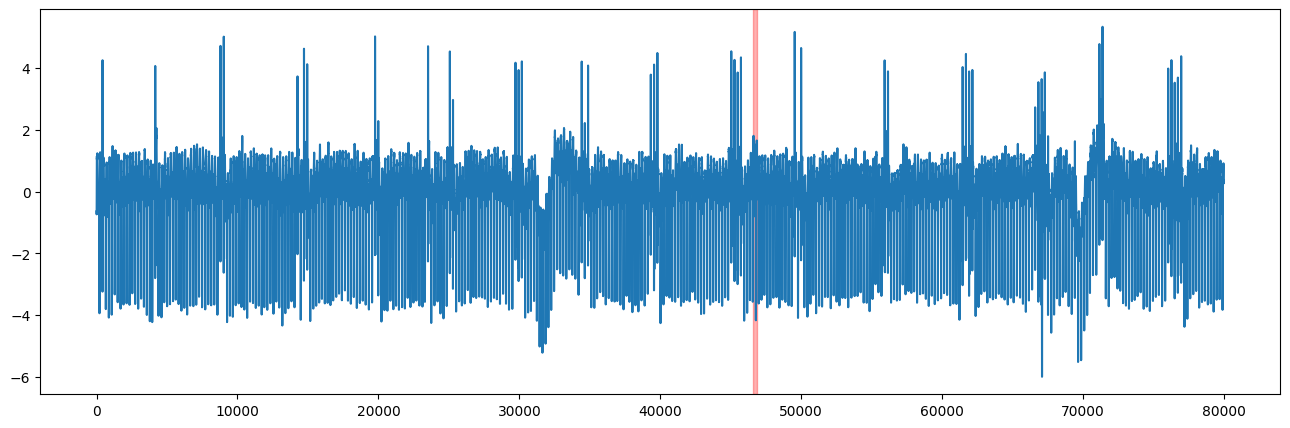

In [17]:
plt.figure(figsize=(16,5))
plt.plot(data.sine_wave.cpu().detach().numpy())
plt.axvspan(data.start,data.end,color="red",alpha=0.3)
plt.tight_layout()

In [19]:
aux.full_anomaly_score

array([0.06397696, 0.0648354 , 0.05879295, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

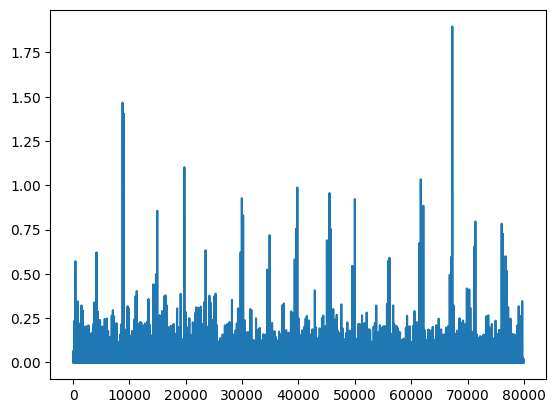

In [13]:
plt.plot(aux.full_anomaly_score)

Epoch: 0
tensor(436.2089, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5467, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(436.2089, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5467, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/17], Loss: 436.1334
tensor(295.0674, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5525, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(295.0674, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5525, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/17], Loss: 294.9919
tensor(266.0931, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(266.0931, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5452, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/17], Loss: 266.0176
tensor(220.7002, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(220.7002, device='cuda:0', grad_fn=<MeanBackward1

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(218.0426, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6730, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(218.0426, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6730, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/17], Loss: 217.9659
tensor(203.4163, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(203.4163, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6401, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/17], Loss: 203.3399
tensor(178.2010, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(178.2010, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6363, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/17], Loss: 178.1246
tensor(168.2970, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6124, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(168.2970, device='cuda:0', grad_fn=<MeanBackward1

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(200.8044, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(200.8044, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5533, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/17], Loss: 200.7288
tensor(197.3855, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(197.3855, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5012, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/17], Loss: 197.3105
tensor(189.5576, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(189.5576, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5324, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/17], Loss: 189.4823
tensor(168.3803, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5393, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(168.3803, device='cuda:0', grad_fn=<MeanBackward1

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(124.8528, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.2894, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(124.8528, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.2894, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/3], Loss: 124.7700
tensor(110.6825, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.3041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.6825, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.3041, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/3], Loss: 110.5995
tensor(106.1758, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.3286, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(106.1758, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.3286, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/3], Loss: 106.0926
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(157.5619, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.5317, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(157.5619, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.5317, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/2], Loss: 157.4766
tensor(161.8638, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.5349, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(161.8638, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.5349, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/2], Loss: 161.7785
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(210.5765, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.6511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(210.5765, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.6511, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/2], Loss: 210.4900
tensor(187.7170, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.6658, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(187.7170, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.6658, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/2], Loss: 187.6303
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(901.2499, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6651, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(901.2499, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6651, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/2], Loss: 901.1732
tensor(727.8645, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(727.8645, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.6636, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/2], Loss: 727.7878
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(453.1316, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7769, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(453.1316, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7769, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/2], Loss: 453.0538
tensor(405.0433, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(405.0433, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7608, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/2], Loss: 404.9657
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(280.6279, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7776, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(280.6279, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7776, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/2], Loss: 280.5501
tensor(271.4371, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.8223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(271.4371, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.8223, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/2], Loss: 271.3589
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(429.8571, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9671, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(429.8571, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9671, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/2], Loss: 429.7774
tensor(314.2968, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(314.2968, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9578, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/2], Loss: 314.2172
Entrenamiento finalizado


/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(161.5607, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5456, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(161.5607, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5456, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/7], Loss: 161.4852
tensor(161.6277, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(161.6277, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5156, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/7], Loss: 161.5526
tensor(145.5082, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5167, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(145.5082, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5167, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/7], Loss: 145.4331
tensor(149.8235, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.5138, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(149.8235, device='cuda:0', grad_fn=<MeanBackward1>) 

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(219.4955, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7720, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(219.4955, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7720, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/7], Loss: 219.4178
tensor(177.8602, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7686, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(177.8602, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7686, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/7], Loss: 177.7826
tensor(173.1956, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7638, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(173.1956, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7638, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/7], Loss: 173.1180
tensor(162.6724, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(162.6724, device='cuda:0', grad_fn=<MeanBackward1>) 

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(188.5188, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(188.5188, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1415, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/7], Loss: 188.4374
tensor(167.4254, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1682, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(167.4254, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1682, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/7], Loss: 167.3437
tensor(158.0093, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(158.0093, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1649, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/7], Loss: 157.9277
tensor(180.4956, device='cuda:0', grad_fn=<MeanBackward1>) tensor(8.1474, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(180.4956, device='cuda:0', grad_fn=<MeanBackward1>) 

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(293.3190, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(293.3190, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9489, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/7], Loss: 293.2395
tensor(260.1550, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9824, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(260.1550, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9824, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/7], Loss: 260.0752
tensor(203.4763, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9073, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(203.4763, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9073, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/7], Loss: 203.3973
tensor(197.5709, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9194, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(197.5709, device='cuda:0', grad_fn=<MeanBackward1>) 

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


Epoch: 0
tensor(307.1651, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(307.1651, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9248, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [1/42], Loss: 307.0859
tensor(236.3707, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(236.3707, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.9015, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [2/42], Loss: 236.2917
tensor(125.8096, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7991, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(125.8096, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7991, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/1], Step [3/42], Loss: 125.7316
tensor(131.4176, device='cuda:0', grad_fn=<MeanBackward1>) tensor(7.7618, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(131.4176, device='cuda:0', grad_fn=<MeanBackward1

/tmp/ipykernel_1178037/458355372.py:284: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))


KeyboardInterrupt: 

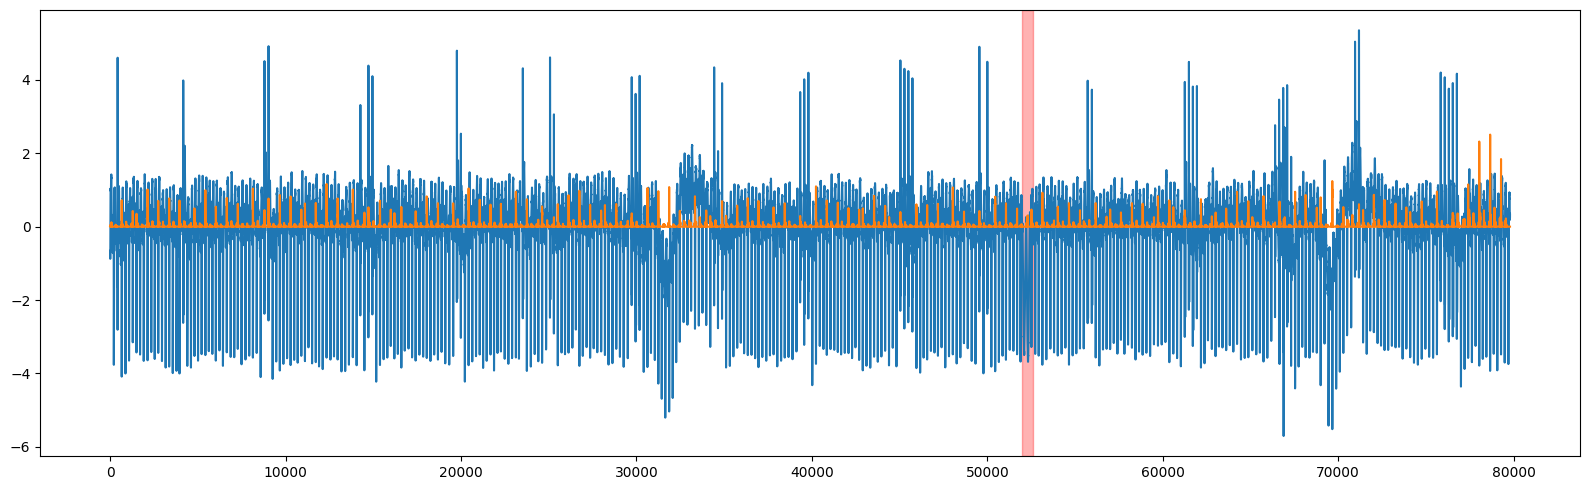

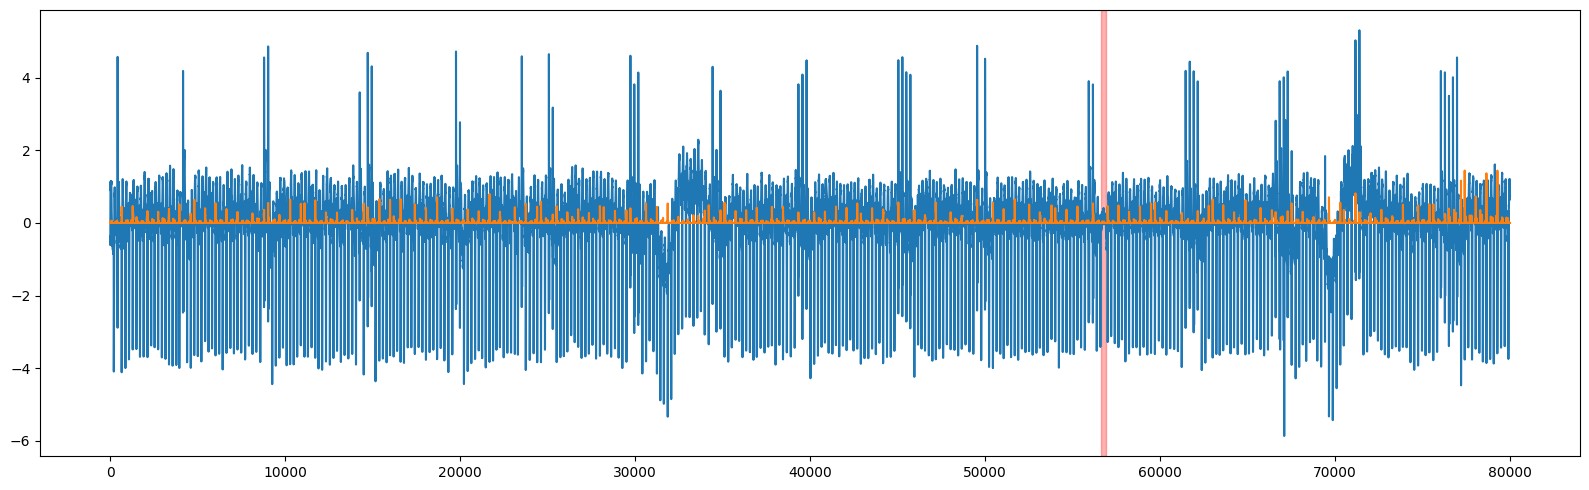

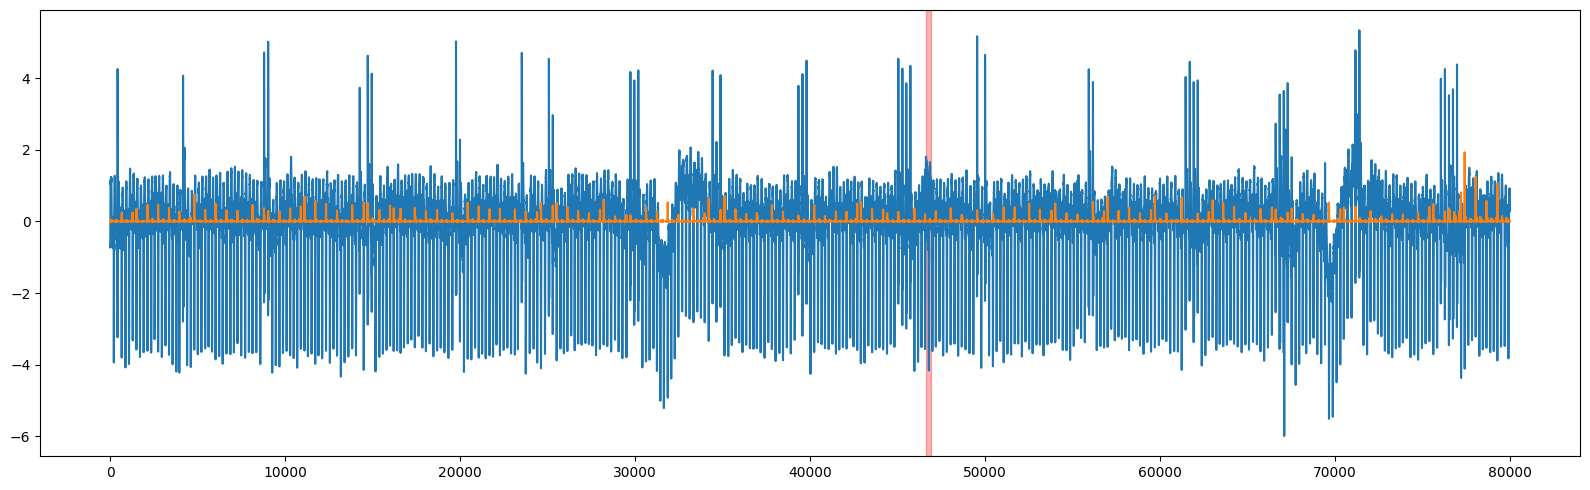

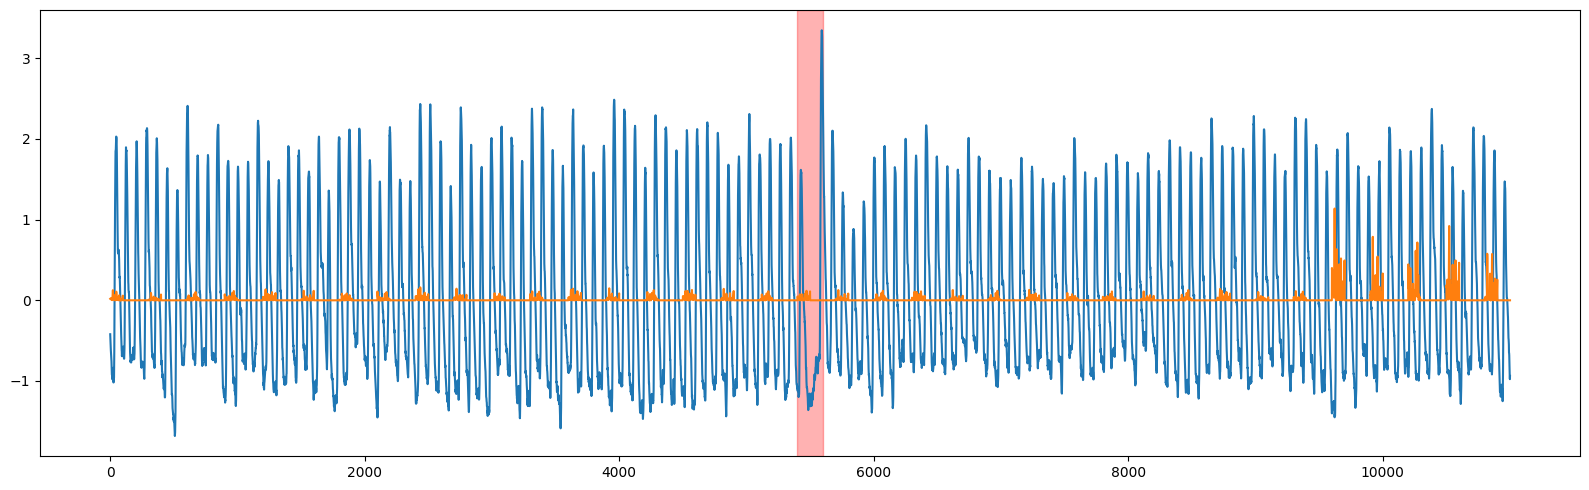

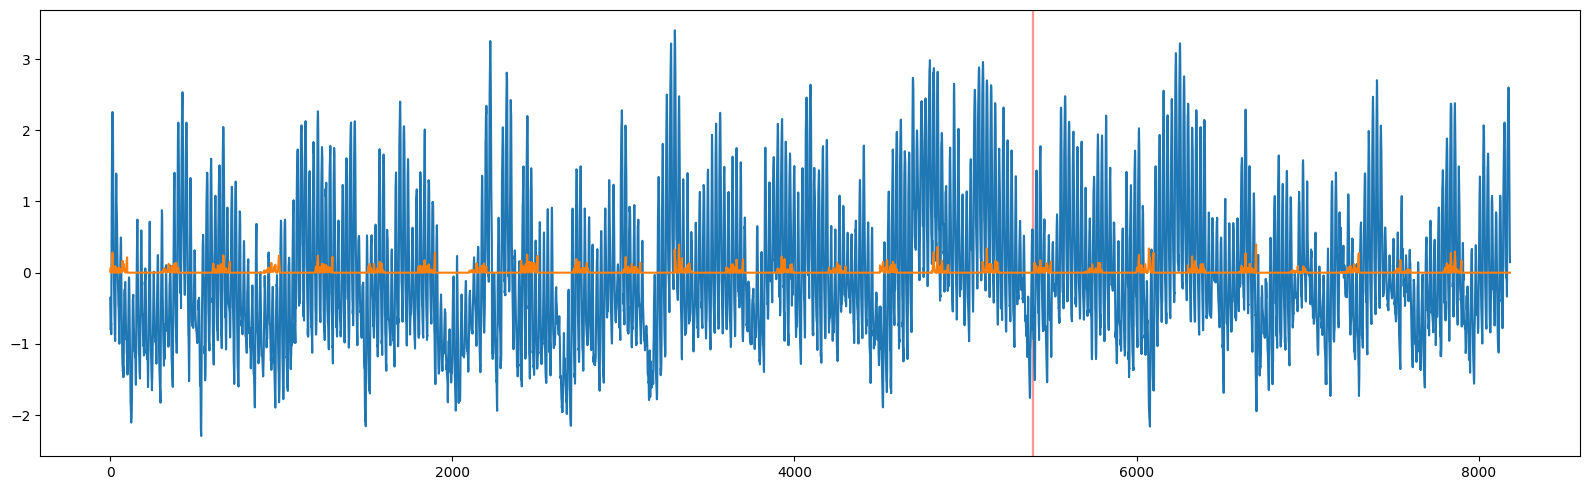

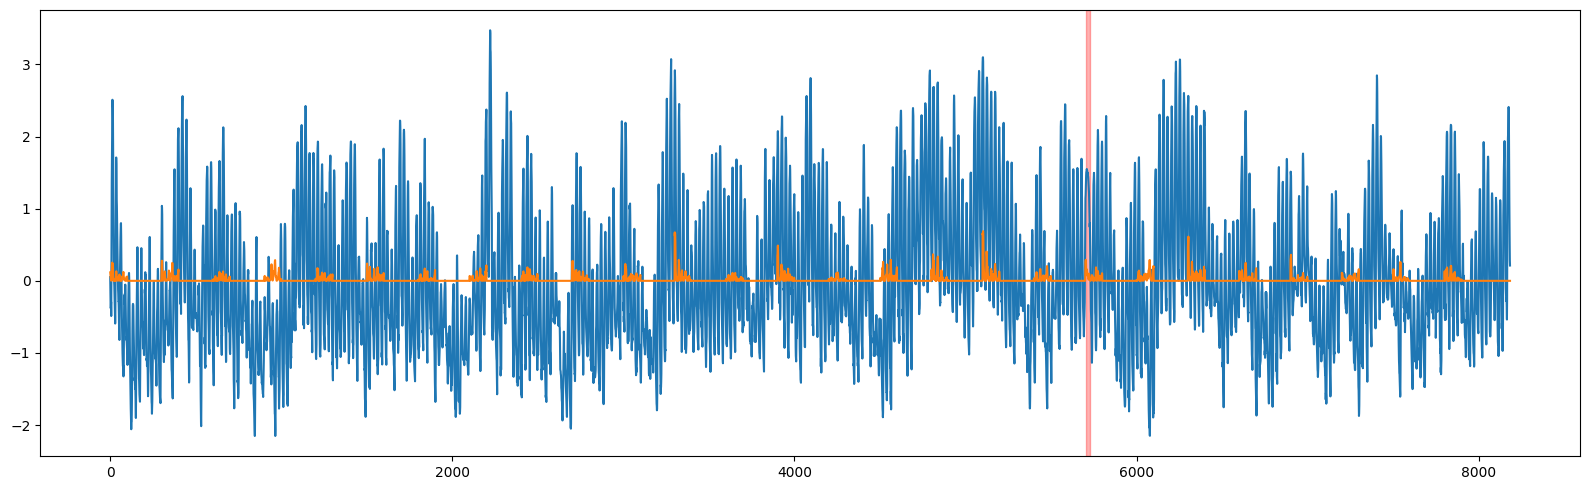

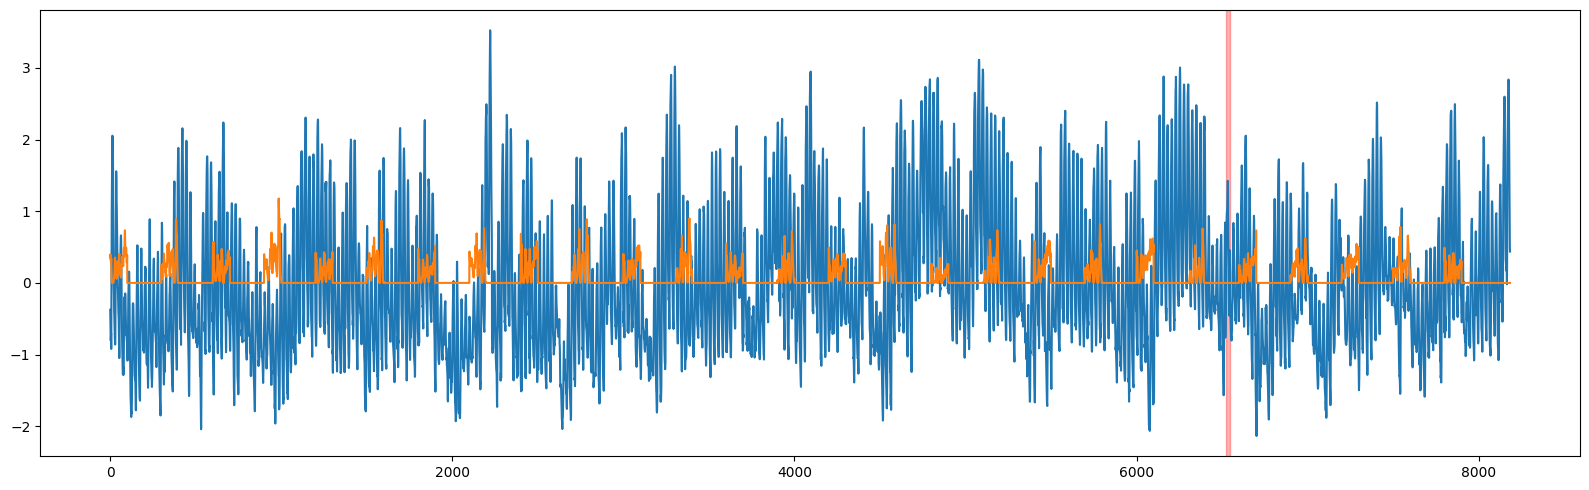

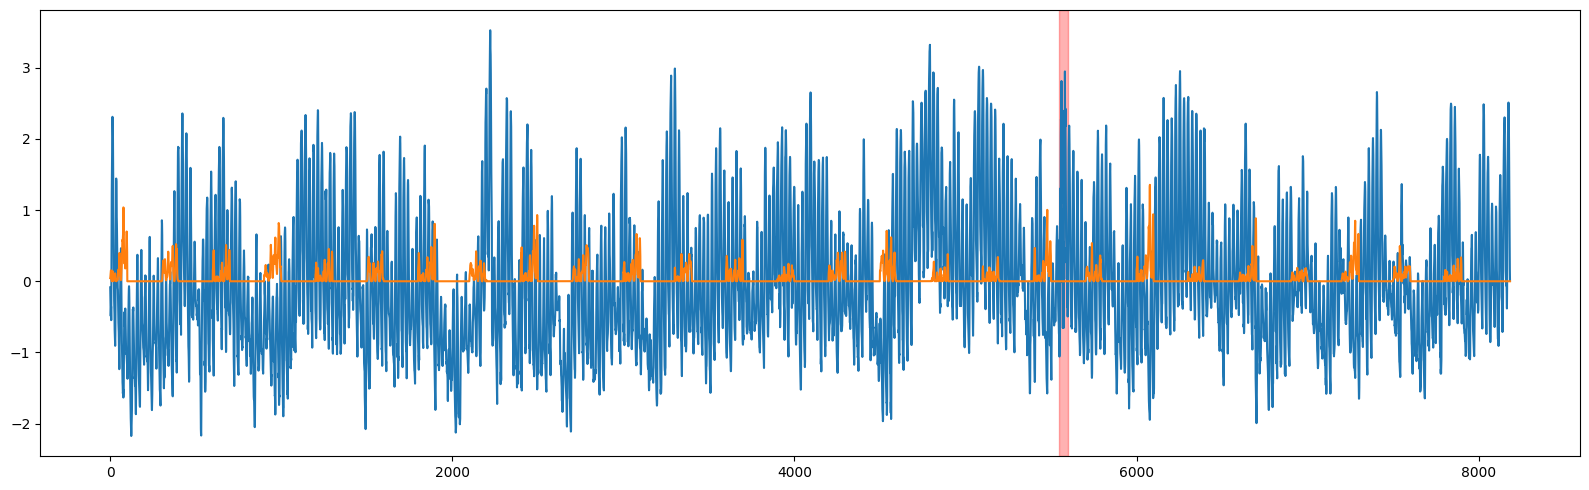

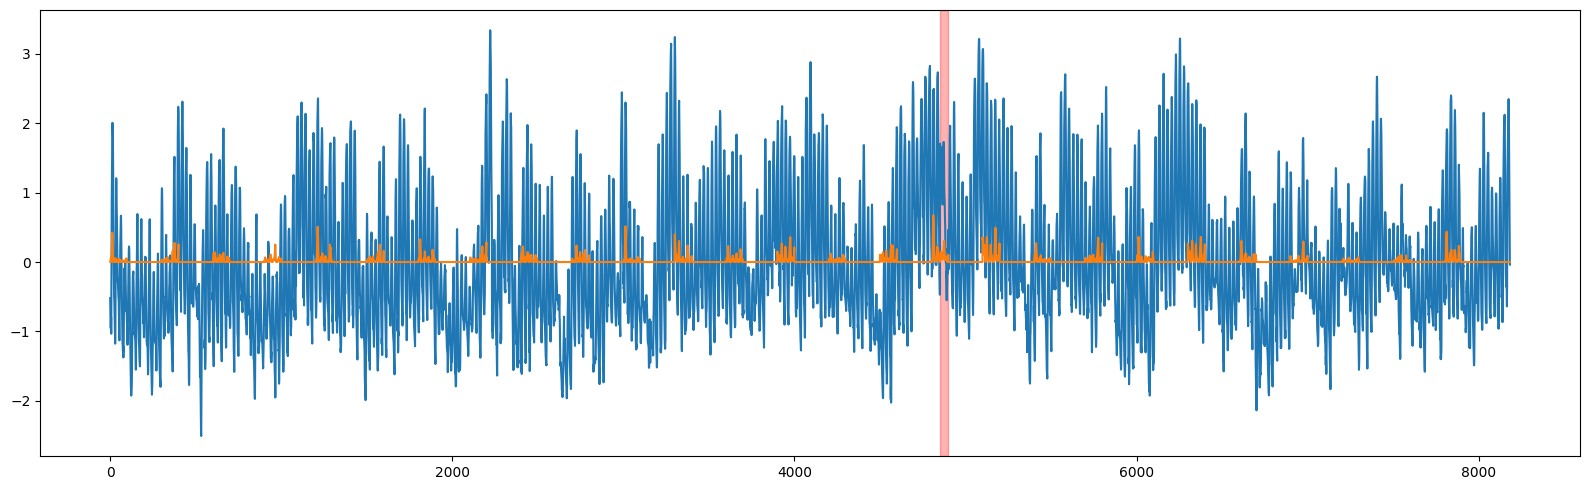

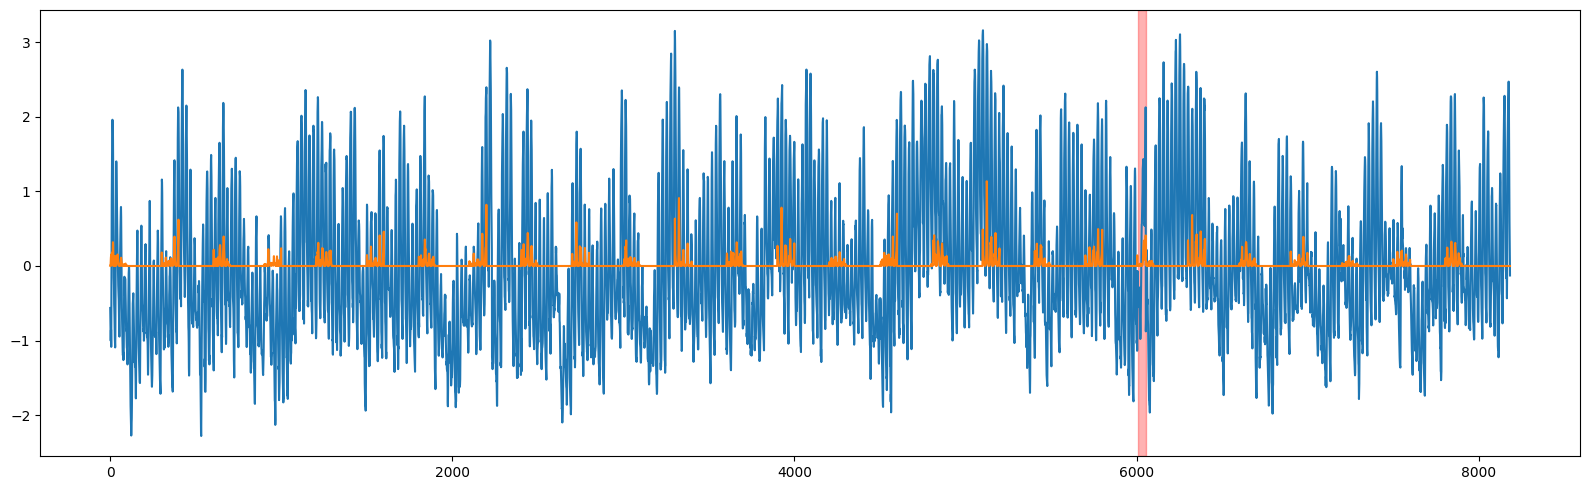

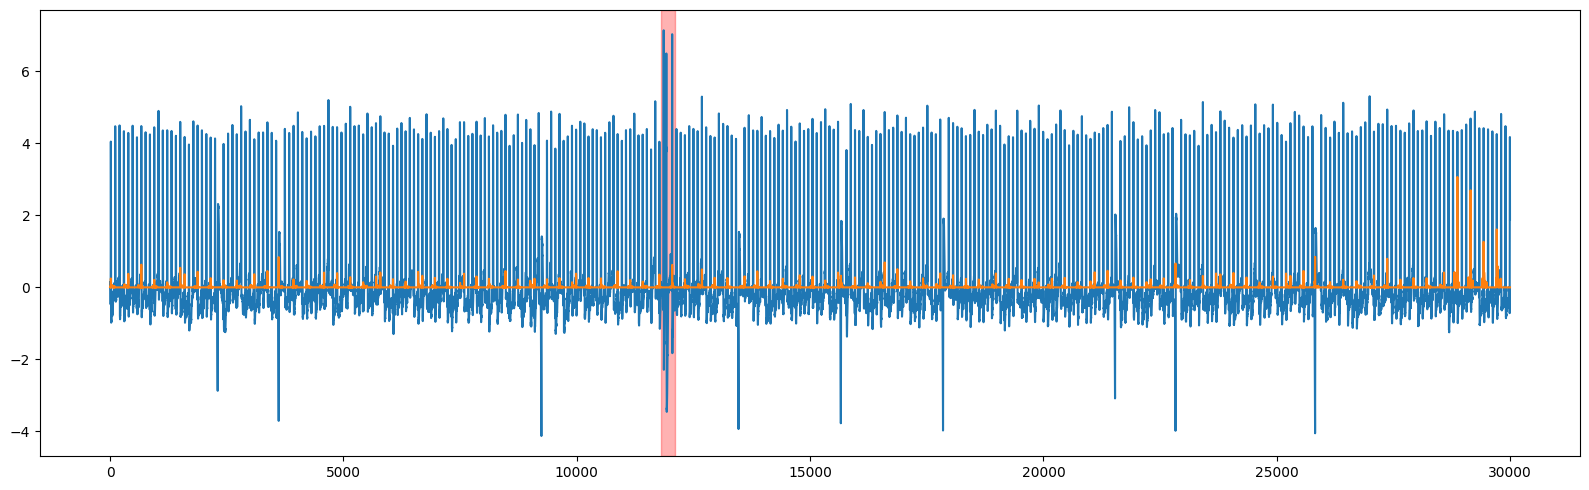

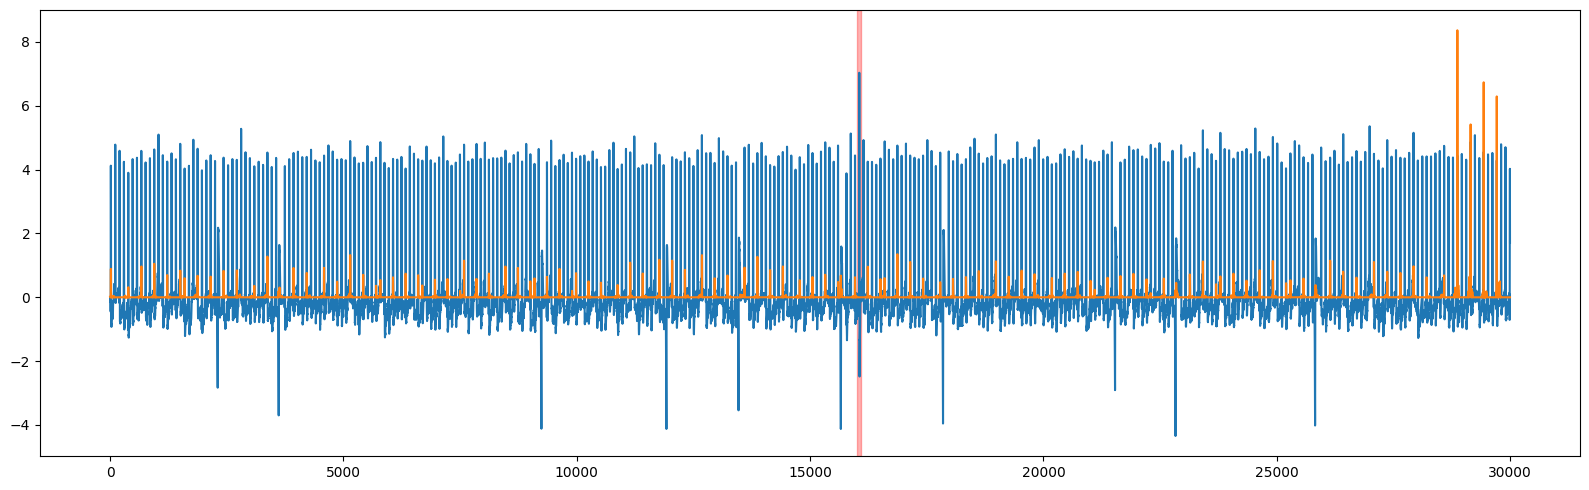

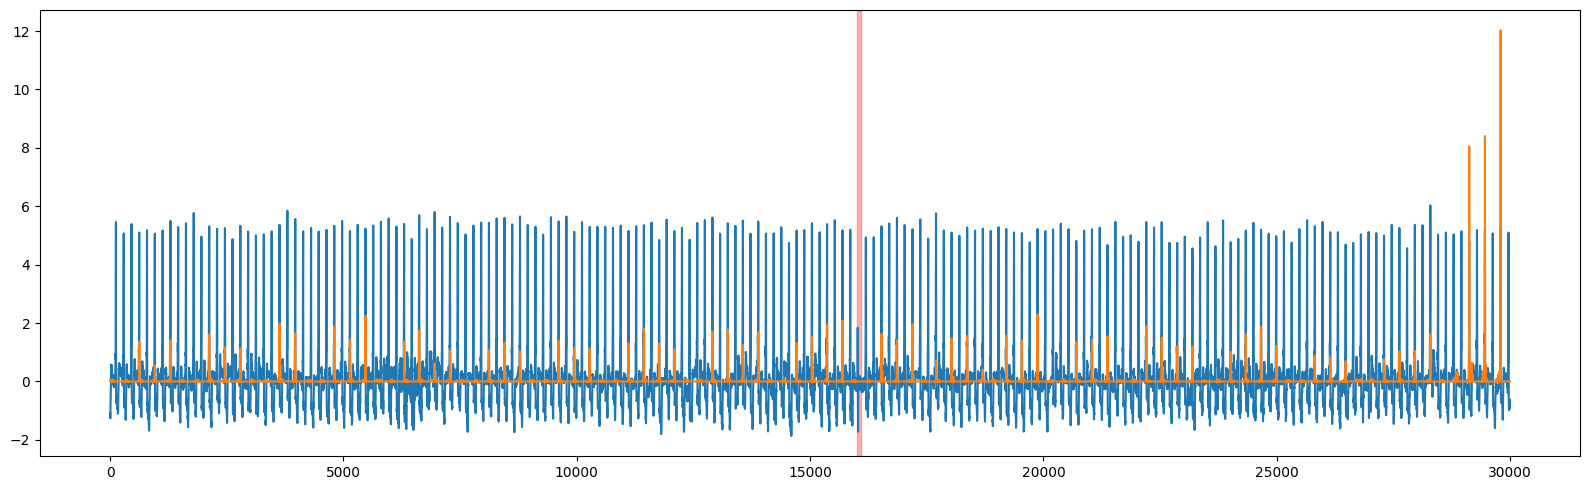

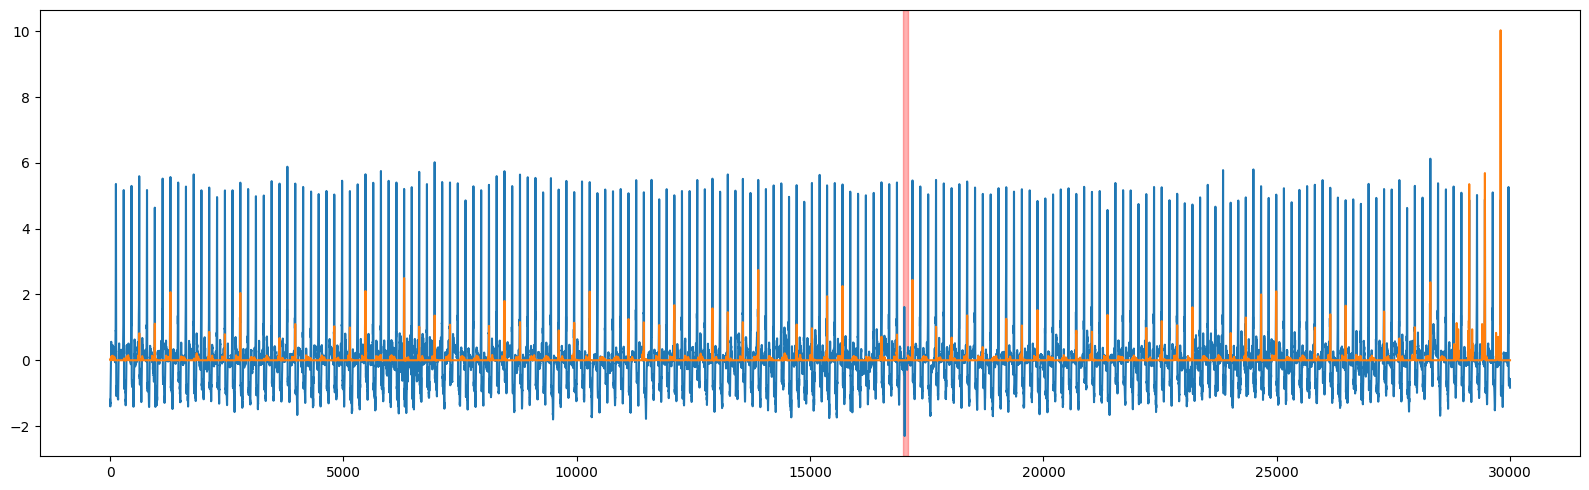

In [20]:
BASE_DIR=".."
data_dir=os.path.join(BASE_DIR,"data2apply/UCR_dataAnomalyArchive")
data = UCRData(data_dir, stride=300, winsize=100, norm=True)

log_file = "progreso.log"
with open(log_file, "a") as log:
    ids = sorted(list(data.dir_data_files.keys()))
    for id in ids:
        log.write(f"Procesando ID: {id}\n")

        data.load_ID(id)
        dataloader = DataLoader(data, batch_size=16, shuffle=True)

        model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, n_heads=3, d_model=128, enc_in=1, enc_out=1, max_norm=None, sigma_a=3, sigma_b=5, clip_sigma="yes")
        model_instance.train(dataloader, 1, 1e-4, 1, 0.01, 0.01)

        del dataloader
        torch.cuda.empty_cache()
        gc.collect()

        aux = EvalModel(model_instance, data, None, None)

        # Crear y guardar el gráfico
        plt.figure(figsize=(16, 5))
        plt.plot(data.sine_wave.cpu().detach().numpy())
        plt.axvspan(data.start, data.end, color="red", alpha=0.3)
        plt.plot(aux.full_anomaly_score)
        plt.tight_layout()
        plt.savefig(f"ID_{id}_plot.png")

        # Guardar información en un fichero
        highest_1_percent = int(len(aux.full_anomaly_score) * 0.01)
        sorted_indices = sorted(range(len(aux.full_anomaly_score)), key=lambda i: aux.full_anomaly_score[i], reverse=True)[:highest_1_percent]
        peaks_in_range = sum(data.start <= idx <= data.end for idx in sorted_indices)

        with open("resultados.txt", "a") as f:
            if peaks_in_range > 0:
                f.write(f"ID: {id}, 1\n")
            else:
                f.write(f"ID: {id}, 0\n")



In [ ]:
import gc
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def main():
    data_dir = "tu_directorio_de_datos"
    data = UCRData(data_dir, stride=100, winsize=100, norm=True)

    log_file = "progreso.log"
    with open(log_file, "a") as log:
        ids = sorted(list(data.dir_data_files.keys()))
        for id in ids:
            log.write(f"Procesando ID: {id}\n")

            data.load_ID(id)
            dataloader = DataLoader(data, batch_size=16, shuffle=True)

            model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, n_heads=3, d_model=128, enc_in=1, enc_out=1, max_norm=None, sigma_a=3, sigma_b=5, clip_sigma="yes")
            model_instance.train(dataloader, 1, 1e-4, 1, 0.01, 0.01)

            del dataloader
            torch.cuda.empty_cache()
            gc.collect()

            aux = EvalModel(model_instance, data, None, None)

            # Crear y guardar el gráfico
            plt.figure(figsize=(16, 5))
            plt.plot(data.sine_wave.cpu().detach().numpy())
            plt.axvspan(data.start, data.end, color="red", alpha=0.3)
            plt.plot(aux.full_anomaly_score)
            plt.tight_layout()
            plt.savefig(f"ID_{id}_plot.png")
            plt.close()

            # Guardar información en un fichero
            highest_1_percent = int(len(aux.full_anomaly_score) * 0.01)
            sorted_indices = sorted(range(len(aux.full_anomaly_score)), key=lambda i: aux.full_anomaly_score[i], reverse=True)[:highest_1_percent]
            peaks_in_range = sum(data.start <= idx <= data.end for idx in sorted_indices)

            with open(f"ID_{id}_registro.txt", "w") as f:
                f.write(f"1% de los picos más altos de full anomaly score que entraron entre start y end: {peaks_in_range}\n")

if __name__ == "__main__":
    main()
